<a href="https://colab.research.google.com/github/Addi-11/Image_Translation/blob/master/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pix2Pix

In [ ]:
import tensorflow as tf
import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
# downloading dataset
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/edges2shoes.tar.gz'
path_to_zip = tf.keras.utils.get_file('edges2shoes.tar.gz', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'edges2shoes/')

KeyboardInterrupt: ignored

In [ ]:
!ls {PATH}

train  val


In [ ]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

## Utlities

In [ ]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [ ]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)
  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

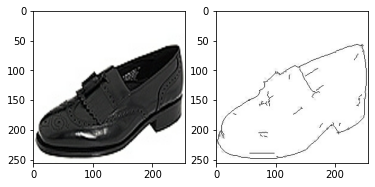

In [ ]:
# testing load funct

inp, re = load(PATH+'train/100_AB.jpg')

plt.subplot(1, 2, 1)
plt.imshow(inp/255.0)
plt.subplot(1, 2, 2)
plt.imshow(re/255.0)

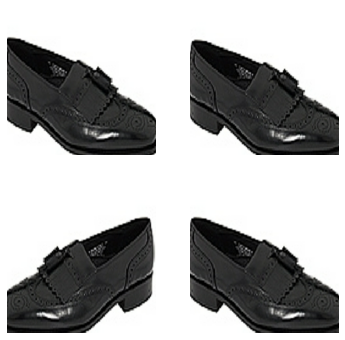

In [ ]:
# testing random jittering
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
plt.show()

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Input Pipeline

In [ ]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch
train_dataset

NameError: ignored

In [ ]:
train_dataset = train_dataset.take(2000)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<BatchDataset shapes: ((None, None, 256, 256, 3), (None, None, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [ ]:
test_dataset = tf.data.Dataset.list_files(PATH+'val/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=200>

# Model Architecture

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
# encoder block
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer() # normal distribution
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.LeakyReLU())

    return model

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [ ]:
# decoder block
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.ReLU())

    return model

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


## Generator

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  encoder_stack = [
    downsample(64, 4, apply_batchnorm=False), 
    downsample(128, 4), 
    downsample(256, 4), 
    downsample(512, 4), 
    downsample(512, 4), 
    downsample(512, 4), 
    downsample(512, 4), 
    downsample(512, 4), 
  ]

  decoder_stack = [
    upsample(512, 4, apply_dropout=True), 
    upsample(512, 4, apply_dropout=True), 
    upsample(512, 4, apply_dropout=True), 
    upsample(512, 4), 
    upsample(256, 4), 
    upsample(128, 4), 
    upsample(64, 4), 
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') 

  x = inputs

  # Downsampling through the model
  skips = []
  for down in encoder_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(decoder_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

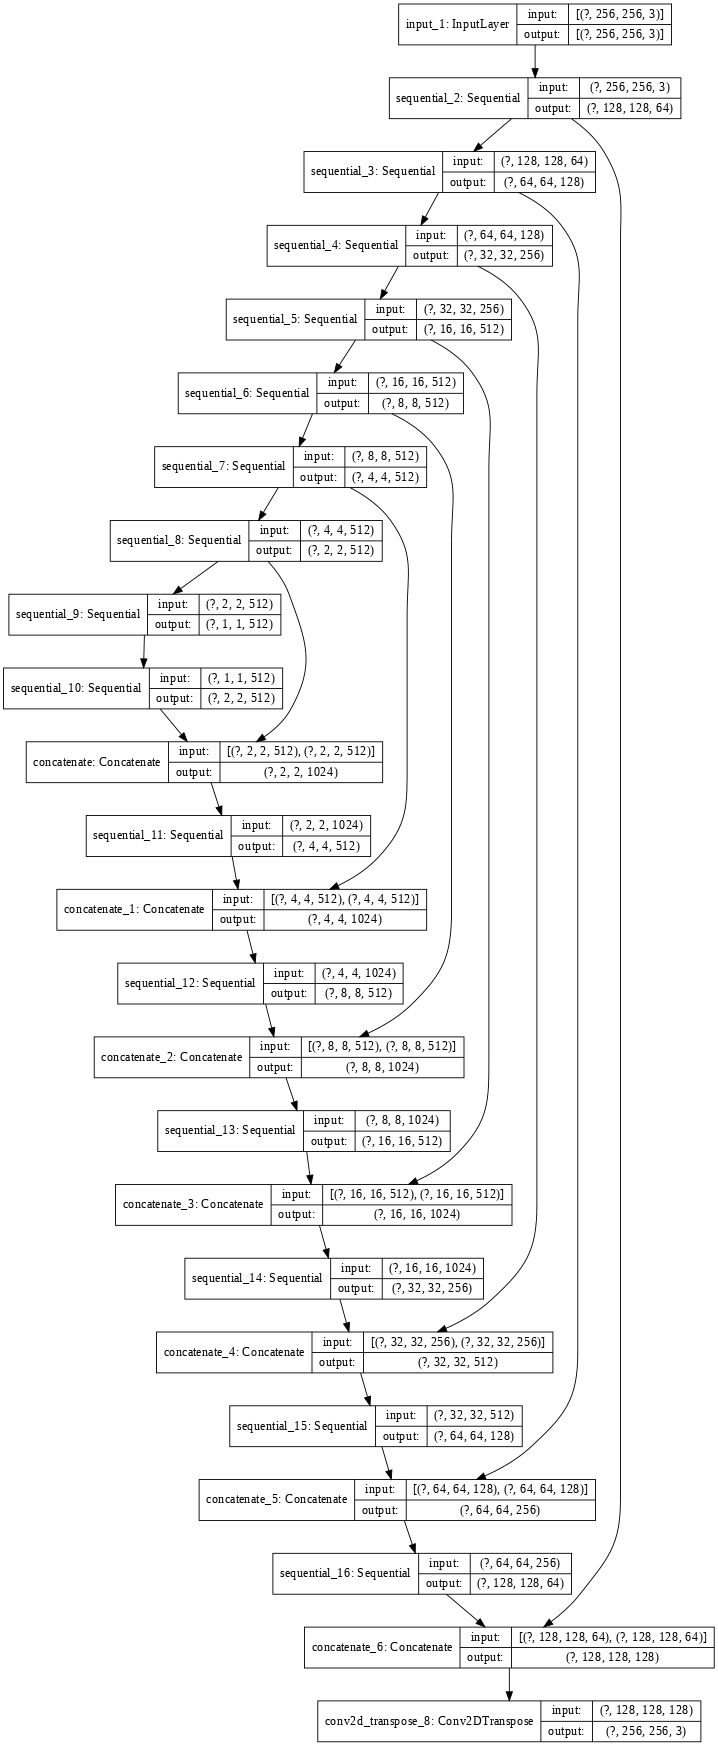

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
# generator.summary()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


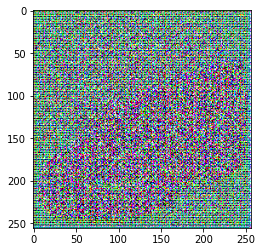

In [ ]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## Discriminator

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) 

    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down2) 

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) 
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                    kernel_initializer=initializer,
                                    use_bias=False)(zero_pad1) 

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) 

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                    kernel_initializer=initializer)(zero_pad2)   
                                    
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

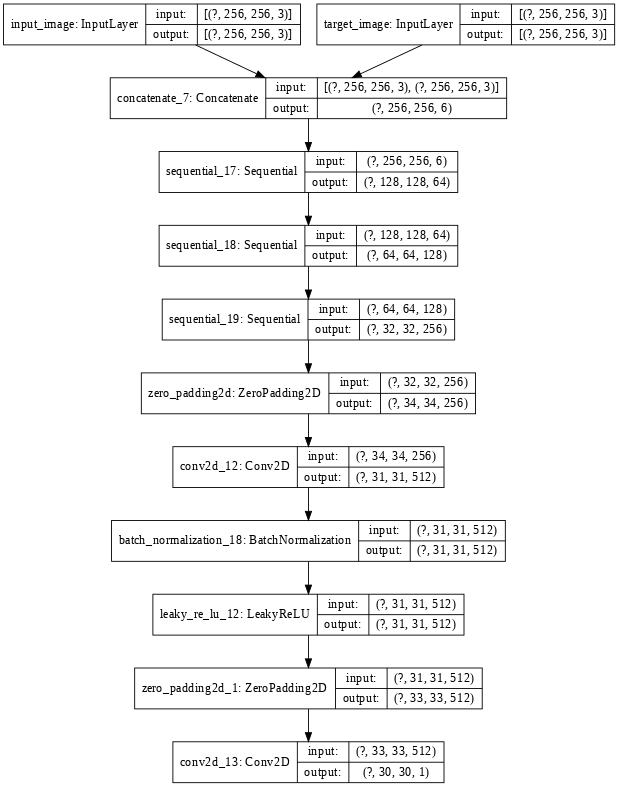

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

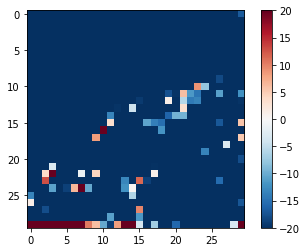

In [ ]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### Optimizers and Checkpoint-saver


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer,
                                 generator=generator, discriminator=discriminator)

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=False)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

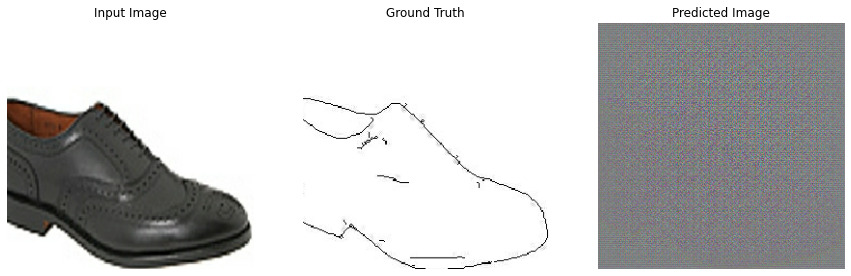

In [ ]:
for example_input, example_target in train_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Training


In [ ]:
EPOCHS = 10

In [ ]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

Training loop


In [ ]:
def fit(train_ds, epochs):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in train_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 5 epochs
    # if (epoch + 1) % 5 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)
    files.download('./training_checkpoints')

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
    
  checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
fit(train_dataset, EPOCHS)

In [ ]:
from google.colab import files
files.download('./training_checkpoints')


## Restore the latest checkpoint and test

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate using test dataset

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)